# Ranking on directed graphs

Here we check the ranking for directed graphs, such as, the directed trinary tree, Scale-free graph, Erdos-Renyi random graph, Random $k$-out graph, GNC graph.

## Programs

These programs are collected from the file "Ranking on nodes directed graph with damping factor.ipynb". Check that file for detailed description.

In [113]:
import math as math
import networkx as nx
import matplotlib.pyplot as plt
import scipy.linalg as lin
import numpy as np
import sympy as sym
from networkx.drawing.nx_pydot import graphviz_layout
import pandas as pd

In [114]:
pi = np.pi

In [115]:
def ket_vector(n, v):
    ket = [0] * n
    ket[v] = 1
    return np.matrix(ket).transpose()

In [116]:
def w_coeff(n, u_0, k):
    return(np.exp(2J*pi * u_0 * k / n))

In [117]:
def Weyl(n, u_0, u_l):
    z = np.matrix(np.zeros((n ,n)))
    for k in range(n):
        w = w_coeff(n, u_0, k)
        z = z + w * ket_vector(n, k) * ket_vector(n, (k + u_l) % n).transpose()
    return(z)

In [118]:
def make_directed(G):
    V = list(G.nodes())
    Vdict = {}
    for v in V:
        E = [(v, v)]
        for u in G.neighbors(v):
            E.append((v,u))
        Vdict[v] = E
    return(Vdict)

In [119]:
def Kraus_dictionary(G):
    n = G.order()
    Kdict = {}
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    for u_0 in list(G.nodes()):
        d = G.out_degree(u_0) + 1
        Kdict[(u_0, u_0)] = np.matrix(np.eye(n))/math.sqrt(d)
        for u_l in G.neighbors(u_0):
            Kdict[(u_0, u_l)] = Weyl(n, u_0, u_l)/math.sqrt(d)
    return(Kdict)

In [120]:
def initial_state(G):
    n = G.order()
    I = np.matrix(np.eye(n))
    list_of_density_matrices = [I/n**2]*n
    return(list_of_density_matrices)

In [121]:
def evolve(G, IS, T):
    n = G.order()
    V = list(G.nodes())
    M = IS.copy()
    Kdict = Kraus_dictionary(G)
    for t in range(0, T):
#         print("t = ", t)
        L = [np.matrix(np.zeros((n , n)))]*n
        for i in range(n):
            u_0 = V[i]
            E = []
            E = list(G.in_edges(u_0)) + [(u_0, u_0)]
            for e in E:
                L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
        P = []
        for i in range(n):
            M[i] = L[i]
            P.append(np.around(np.trace(M[i]), 4))
#         print(P)
    dic = {}
    for i in range(n):
        dic[i] = P[i]
    return(dic)

In [122]:
def evolve_with_damping(G, IS, T, alpha):
    n = G.order()
    V = list(G.nodes())
    M = IS.copy()
    Kdict = Kraus_dictionary(G)
    for t in range(0, T):
#         print("t = ", t)
        L = [np.matrix(np.zeros((n , n)))]*n
        for i in range(n):
            u_0 = V[i]
            E = []
            E = list(G.in_edges(u_0)) + [(u_0, u_0)]
            for e in E:
                L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
        P = []
        Dump = sum(M)
        for i in range(n):
#             M[i] = L[i]
            M[i] = alpha * L[i] + (1 - alpha) * Dump / n
            P.append(np.around(np.trace(M[i]), 4))
#         print(P)
#     dic = {}
#     for i in range(n):
#         dic[i] = P[i]
    return(P)

In [123]:
def one_step_evolution(G, alpha, M):
    n = G.order()
    V = list(G.nodes())
    Kdict = Kraus_dictionary(G)
    L = [np.matrix(np.zeros((n , n)))]*n
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    for i in range(n):
        u_0 = V[i]
        E = []
        E = list(G.in_edges(u_0)) + [(u_0, u_0)]
        for e in E:
            L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
    Dump = sum(M)
    for i in range(n):
        L[i] = alpha * L[i] + (1 - alpha) * Dump / n
    return(L)

In [124]:
def find_probability(M):
    n = len(M)
    P = []
    for i in range(n):
        P.append(np.around(np.trace(M[i]), 4))
    return(P)

In [125]:
def q_rank(G, alpha):
    n = G.order()
    V = list(G.nodes())
    Kdict = Kraus_dictionary(G)
    IS = initial_state(G)
    M = IS.copy()
    P = []
    P = find_probability(M)
    Q = [1]*n
    t = 1
    while lin.norm(np.array(P) - np.array(Q)) >= .0001:
        P = []
        P = Q
#         print(P)
        L = one_step_evolution(G, .85, M)
        Q = []
        Q = find_probability(L)
#         print(Q)
        M = []
        M = L.copy()
        t = t + 1
    dic = {}
    for i in range(n):
        dic[i] = np.real(np.around(Q[i], 4))
    return(dic, t)

In [126]:
def Google_matrix(G, alpha):
    n = G.order()
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    O = np.ones(n)
    A = nx.adjacency_matrix(G).A
    S = np.zeros((n, n))
    for i in range(n):
        if G.out_degree(i) != 0:
            d = G.out_degree(i)
            S[i] = A[i]/d
        else:
            S[i] = np.ones(n)/n
    Google = alpha * S + (1 - alpha)*O/n
    return(Google)

In [127]:
def page_rank(G, alpha):
    Google = np.matrix(Google_matrix(G, alpha))
    n = G.order()
    w = np.ones(n) / n
    v = w*Google
    t = 1
    while np.linalg.norm(w - v) >= .0001:
        w = v
        v = w*Google
        t = t + 1
    dic = {}
    v = np.array(v)[0]
    for i in range(n):
        dic[i] = np.around(v[i], 4)
    return(dic, t)
#     return(v)

In [128]:
def find_ranks_of_vertices(P):
    L = sorted(P.items(), key=lambda x: x[1], reverse=True)
    R = {}
    for element in L:
        R[element[0]] = L.index(element) + 1
    sorted_Ranks = dict(sorted(R.items()))
    return(sorted_Ranks)

## Examples on undirected graphs

### Directed Trinary tree

In [129]:
r = 3
h = 2
H = nx.balanced_tree(r, h)

Here we take the edge orientations from the center to the outer layer. 

In [130]:
G = nx.DiGraph()
H.add_nodes_from(H.nodes())
E = list(H.edges())
G.add_edges_from(E)

Thanks to https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx

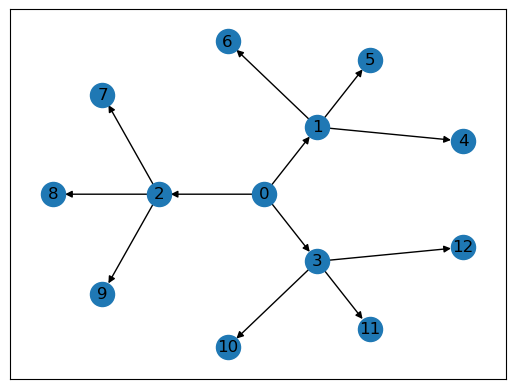

In [131]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

In [132]:
P = nx.pagerank(G)
for key in P.keys():
    P[key] = round(P[key], 4)
P

{0: 0.0584,
 1: 0.0749,
 2: 0.0749,
 3: 0.0749,
 4: 0.0796,
 5: 0.0796,
 6: 0.0796,
 7: 0.0796,
 8: 0.0796,
 9: 0.0796,
 10: 0.0796,
 11: 0.0796,
 12: 0.0796}

In [133]:
Q, t = q_rank(G, .85)
Q

{0: 0.0147,
 1: 0.0186,
 2: 0.0186,
 3: 0.0186,
 4: 0.1033,
 5: 0.1033,
 6: 0.1033,
 7: 0.1033,
 8: 0.1033,
 9: 0.1033,
 10: 0.1033,
 11: 0.1033,
 12: 0.1033}

In [22]:
P1 = np.real(list(P.values()))
P1

array([0.0584, 0.0749, 0.0749, 0.0749, 0.0796, 0.0796, 0.0796, 0.0796,
       0.0796, 0.0796, 0.0796, 0.0796, 0.0796])

In [23]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0147, 0.0186, 0.0186, 0.0186, 0.1033, 0.1033, 0.1033, 0.1033,
       0.1033, 0.1033, 0.1033, 0.1033, 0.1033])

In [24]:
new_dict = pd.DataFrame([P1,Q1]).to_dict('list')
new_dict

{0: [0.0584, 0.0147],
 1: [0.0749, 0.0186],
 2: [0.0749, 0.0186],
 3: [0.0749, 0.0186],
 4: [0.0796, 0.1033],
 5: [0.0796, 0.1033],
 6: [0.0796, 0.1033],
 7: [0.0796, 0.1033],
 8: [0.0796, 0.1033],
 9: [0.0796, 0.1033],
 10: [0.0796, 0.1033],
 11: [0.0796, 0.1033],
 12: [0.0796, 0.1033]}

In [25]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

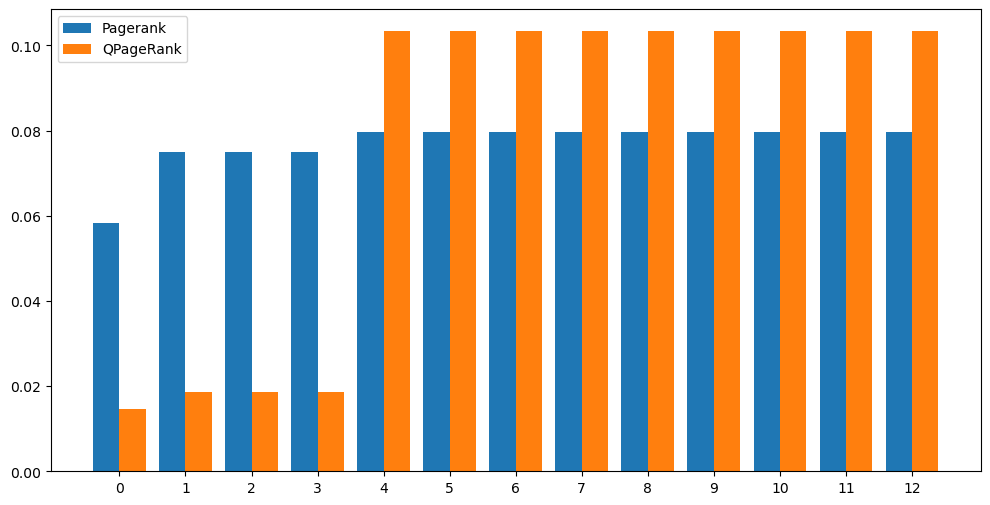

In [26]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [27]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 13,
 1: 10,
 2: 11,
 3: 12,
 4: 1,
 5: 2,
 6: 3,
 7: 4,
 8: 5,
 9: 6,
 10: 7,
 11: 8,
 12: 9}

In [28]:
qPageRanks = find_ranks_of_vertices(Q)
qPageRanks

{0: 13,
 1: 10,
 2: 11,
 3: 12,
 4: 1,
 5: 2,
 6: 3,
 7: 4,
 8: 5,
 9: 6,
 10: 7,
 11: 8,
 12: 9}

In [29]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [30]:
df["PageRanks"].corr(df["qPageRanks"])

1.0

In [31]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12
PageRanks   13  10  11  12   1   2   3   4   5   6   7   8   9
qPageRanks  13  10  11  12   1   2   3   4   5   6   7   8   9


### Scale free graph

B. Bollobás, C. Borgs, J. Chayes, and O. Riordan, Directed scale-free graphs, Proceedings of the fourteenth annual ACM-SIAM Symposium on Discrete Algorithms, 132–139, 2003.

Here the graph may have loops in the vertices. We remove the loops after generating the graph. Also, we calculate the ranks for connected graphs only.

In [139]:
H = nx.scale_free_graph(20)
H.remove_edges_from(nx.selfloop_edges(H))
nx.is_weakly_connected(H)

True

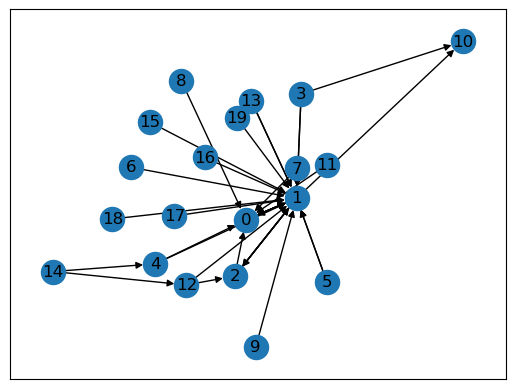

In [141]:
nx.draw_networkx(H)

In [142]:
V = list(H.nodes())
V

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [143]:
E = list(H.edges())
E

[(0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 2),
 (1, 2),
 (1, 0),
 (1, 0),
 (1, 10),
 (2, 0),
 (2, 1),
 (2, 1),
 (3, 1),
 (3, 1),
 (3, 10),
 (4, 1),
 (4, 0),
 (5, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (7, 1),
 (7, 0),
 (8, 0),
 (9, 1),
 (11, 0),
 (12, 1),
 (12, 2),
 (13, 1),
 (13, 1),
 (14, 4),
 (14, 12),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1)]

In [148]:
V = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
E = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (1, 2), (1, 2), (1, 0), (1, 0), (1, 10), (2, 0),
 (2, 1), (2, 1), (3, 1), (3, 1), (3, 10), (4, 1), (4, 0), (5, 1), (5, 1), (6, 1), (7, 1), (7, 1), (7, 0), (8, 0),
 (9, 1), (11, 0), (12, 1), (12, 2), (13, 1), (13, 1), (14, 4), (14, 12), (15, 1), (16, 1), (17, 1), (18, 1),
 (19, 1)]
G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(E)

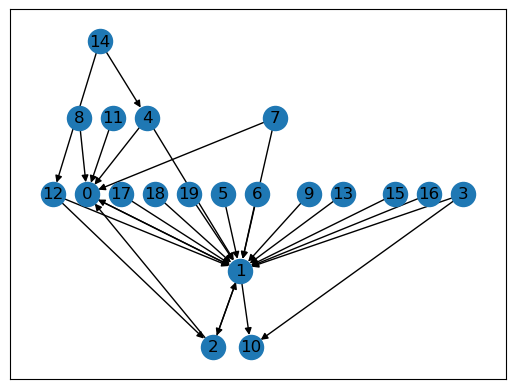

In [149]:
pos = graphviz_layout(G, prog="dot")
nx.draw_networkx(G, pos)
plt.show()

In [150]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_56722/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.1978,
 1: 0.3532,
 2: 0.1202,
 3: 0.0125,
 4: 0.0178,
 5: 0.0125,
 6: 0.0125,
 7: 0.0125,
 8: 0.0125,
 9: 0.0125,
 10: 0.1179,
 11: 0.0125,
 12: 0.0178,
 13: 0.0125,
 14: 0.0125,
 15: 0.0125,
 16: 0.0125,
 17: 0.0125,
 18: 0.0125,
 19: 0.0125}

In [151]:
t

12

In [152]:
Q, t = q_rank(G, .85)
Q

{0: 0.1578,
 1: 0.2037,
 2: 0.0767,
 3: 0.0105,
 4: 0.0146,
 5: 0.013,
 6: 0.013,
 7: 0.0105,
 8: 0.013,
 9: 0.013,
 10: 0.3578,
 11: 0.013,
 12: 0.0146,
 13: 0.013,
 14: 0.0105,
 15: 0.013,
 16: 0.013,
 17: 0.013,
 18: 0.013,
 19: 0.013}

In [153]:
t

27

In [154]:
P1 = np.real(list(P.values()))
P1

array([0.1978, 0.3532, 0.1202, 0.0125, 0.0178, 0.0125, 0.0125, 0.0125,
       0.0125, 0.0125, 0.1179, 0.0125, 0.0178, 0.0125, 0.0125, 0.0125,
       0.0125, 0.0125, 0.0125, 0.0125])

In [155]:
Q1 = np.real(list(Q.values()))
Q1

array([0.1578, 0.2037, 0.0767, 0.0105, 0.0146, 0.013 , 0.013 , 0.0105,
       0.013 , 0.013 , 0.3578, 0.013 , 0.0146, 0.013 , 0.0105, 0.013 ,
       0.013 , 0.013 , 0.013 , 0.013 ])

In [156]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

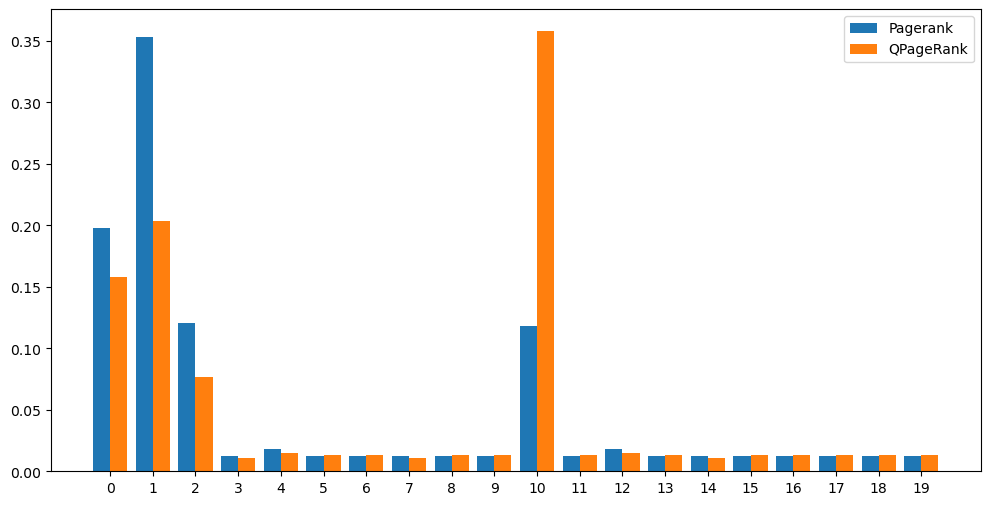

In [157]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [158]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 2,
 1: 1,
 2: 3,
 3: 7,
 4: 5,
 5: 8,
 6: 9,
 7: 10,
 8: 11,
 9: 12,
 10: 4,
 11: 13,
 12: 6,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20}

In [61]:
qPageRanks = find_ranks_of_vertices(Q)
qPageRanks

{0: 2,
 1: 4,
 2: 1,
 3: 17,
 4: 8,
 5: 20,
 6: 18,
 7: 3,
 8: 15,
 9: 16,
 10: 9,
 11: 19,
 12: 10,
 13: 11,
 14: 12,
 15: 13,
 16: 6,
 17: 7,
 18: 5,
 19: 14}

In [159]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [160]:
df["PageRanks"].corr(df["qPageRanks"])

0.7428571428571428

In [161]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
PageRanks    2   1   3   7   5   8   9  10  11  12   4  13   6  14  15  16   
qPageRanks   1   2   4   3   5   6  15   8  12   9   7  16  17  20  11  10   

            16  17  18  19  
PageRanks   17  18  19  20  
qPageRanks  13  18  14  19  


### erdos_renyi_graph

[1] Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959).
[2] Gilbert, Random Graphs, Ann. Math. Stat., 30, 1141 (1959).

https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html

Here the graph may have loops in the vertices. We remove the loops after generating the graph. Also, we calculate the ranks for connected graphs only.

In [162]:
H = nx.erdos_renyi_graph(20, .1, seed = None, directed = True)
H.remove_edges_from(nx.selfloop_edges(G))
nx.is_weakly_connected(H)

True

In [163]:
V = list(H.nodes())
V

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [164]:
E = list(H.edges())
E

[(0, 14),
 (0, 15),
 (1, 4),
 (1, 10),
 (2, 0),
 (2, 6),
 (3, 6),
 (3, 8),
 (3, 17),
 (4, 2),
 (4, 5),
 (4, 10),
 (5, 0),
 (5, 8),
 (5, 9),
 (6, 12),
 (7, 6),
 (8, 7),
 (8, 11),
 (8, 15),
 (9, 7),
 (9, 14),
 (9, 18),
 (10, 6),
 (11, 2),
 (11, 16),
 (12, 4),
 (12, 7),
 (12, 16),
 (13, 3),
 (13, 8),
 (13, 10),
 (14, 15),
 (15, 4),
 (15, 14),
 (15, 16),
 (15, 19),
 (17, 3),
 (17, 4),
 (17, 16),
 (17, 18),
 (18, 5),
 (18, 9),
 (18, 16),
 (19, 10)]

In [165]:
V = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
E = [(0, 14), (0, 15), (1, 4), (1, 10), (2, 0), (2, 6), (3, 6), (3, 8), (3, 17), (4, 2), (4, 5), (4, 10), (5, 0),
 (5, 8), (5, 9), (6, 12), (7, 6), (8, 7), (8, 11), (8, 15), (9, 7), (9, 14), (9, 18), (10, 6), (11, 2), (11, 16),
 (12, 4), (12, 7), (12, 16), (13, 3), (13, 8), (13, 10), (14, 15), (15, 4), (15, 14), (15, 16), (15, 19), (17, 3),
 (17, 4), (17, 16), (17, 18), (18, 5), (18, 9), (18, 16), (19, 10)]
G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(E)

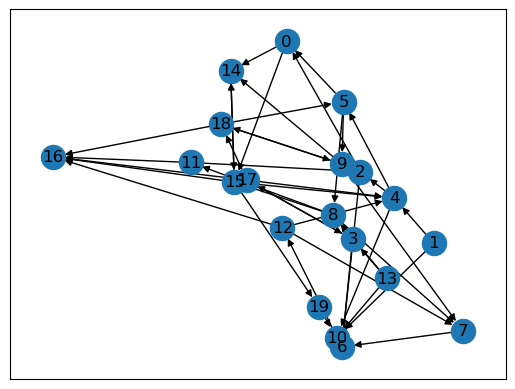

In [166]:
nx.draw_networkx(G)

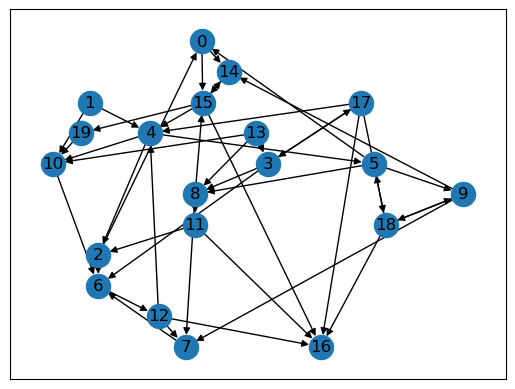

In [167]:
pos = graphviz_layout(G, prog="dot")
nx.draw_networkx(G, pos)
plt.show()

In [168]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_56722/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.0391,
 1: 0.0111,
 2: 0.0404,
 3: 0.0176,
 4: 0.074,
 5: 0.0384,
 6: 0.1431,
 7: 0.0652,
 8: 0.0301,
 9: 0.0283,
 10: 0.064,
 11: 0.0196,
 12: 0.1327,
 13: 0.0111,
 14: 0.053,
 15: 0.0813,
 16: 0.0841,
 17: 0.0161,
 18: 0.0225,
 19: 0.0283}

In [169]:
t

14

In [170]:
Q, t = q_rank(G, .85)
Q

{0: 0.031,
 1: 0.0105,
 2: 0.0315,
 3: 0.0149,
 4: 0.0475,
 5: 0.0273,
 6: 0.1211,
 7: 0.0575,
 8: 0.0235,
 9: 0.0218,
 10: 0.0603,
 11: 0.0174,
 12: 0.0749,
 13: 0.0095,
 14: 0.0518,
 15: 0.0521,
 16: 0.288,
 17: 0.0128,
 18: 0.0182,
 19: 0.0285}

In [171]:
t

31

In [172]:
P1 = np.real(list(P.values()))
P1

array([0.0391, 0.0111, 0.0404, 0.0176, 0.074 , 0.0384, 0.1431, 0.0652,
       0.0301, 0.0283, 0.064 , 0.0196, 0.1327, 0.0111, 0.053 , 0.0813,
       0.0841, 0.0161, 0.0225, 0.0283])

In [173]:
Q1 = np.real(list(Q.values()))
Q1

array([0.031 , 0.0105, 0.0315, 0.0149, 0.0475, 0.0273, 0.1211, 0.0575,
       0.0235, 0.0218, 0.0603, 0.0174, 0.0749, 0.0095, 0.0518, 0.0521,
       0.288 , 0.0128, 0.0182, 0.0285])

In [174]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

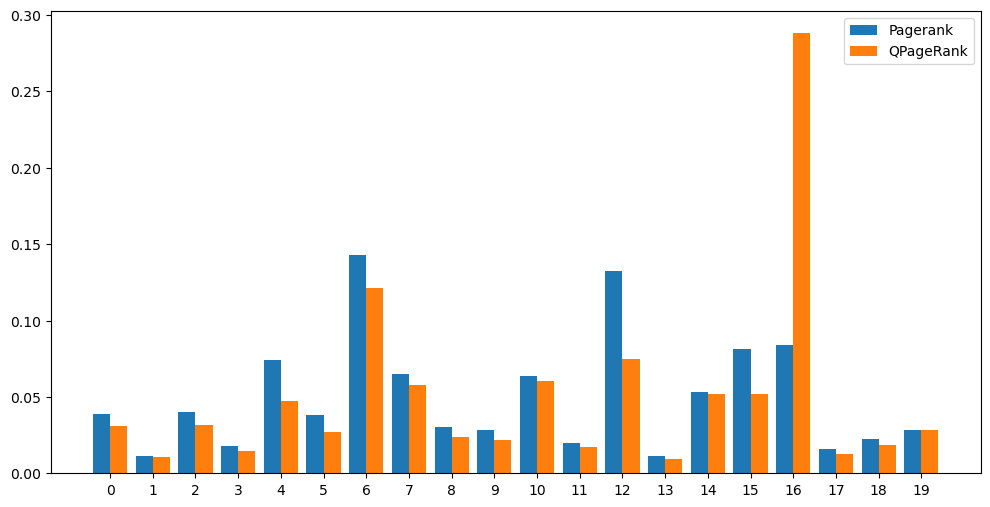

In [175]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [176]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 10,
 1: 19,
 2: 9,
 3: 17,
 4: 5,
 5: 11,
 6: 1,
 7: 6,
 8: 12,
 9: 13,
 10: 7,
 11: 16,
 12: 2,
 13: 20,
 14: 8,
 15: 4,
 16: 3,
 17: 18,
 18: 15,
 19: 14}

In [177]:
qPageRanks = find_ranks_of_vertices(Q)
qPageRanks

{0: 10,
 1: 19,
 2: 9,
 3: 17,
 4: 8,
 5: 12,
 6: 2,
 7: 5,
 8: 13,
 9: 14,
 10: 4,
 11: 16,
 12: 3,
 13: 20,
 14: 7,
 15: 6,
 16: 1,
 17: 18,
 18: 15,
 19: 11}

In [178]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [179]:
df["PageRanks"].corr(df["qPageRanks"])

0.9684210526315788

In [180]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
PageRanks   10  19   9  17   5  11   1   6  12  13   7  16   2  20   8   4   
qPageRanks  10  19   9  17   8  12   2   5  13  14   4  16   3  20   7   6   

            16  17  18  19  
PageRanks    3  18  15  14  
qPageRanks   1  18  15  11  


### random k out graph

Peterson, Nicholas R., and Boris Pittel. “Distance between two random k-out digraphs, with and without preferential attachment.” arXiv preprint arXiv:1311.5961 (2013). <https://arxiv.org/abs/1311.5961>

https://networkx.org/documentation/stable/reference/generated/networkx.generators.directed.random_k_out_graph.html

Here the graph may have loops in the vertices. We remove the loops after generating the graph. Also, we calculate the ranks for connected graphs only.

In [181]:
H = nx.random_k_out_graph(20, 3, 1, self_loops = False, seed=None)
# G.remove_edges_from(nx.selfloop_edges(G))
nx.is_weakly_connected(H)

True

In [182]:
V = list(H.nodes())
V

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [183]:
E = list(H.edges())
E

[(0, 1),
 (0, 7),
 (0, 18),
 (1, 14),
 (1, 14),
 (1, 14),
 (2, 11),
 (2, 14),
 (2, 15),
 (3, 2),
 (3, 11),
 (3, 15),
 (4, 14),
 (4, 18),
 (4, 11),
 (5, 18),
 (5, 18),
 (5, 10),
 (6, 18),
 (6, 1),
 (6, 15),
 (7, 6),
 (7, 13),
 (7, 8),
 (8, 2),
 (8, 18),
 (8, 0),
 (9, 19),
 (9, 18),
 (9, 11),
 (10, 13),
 (10, 5),
 (10, 1),
 (11, 8),
 (11, 19),
 (11, 7),
 (12, 13),
 (12, 1),
 (12, 18),
 (13, 14),
 (13, 19),
 (13, 18),
 (14, 1),
 (14, 1),
 (14, 19),
 (15, 18),
 (15, 13),
 (15, 1),
 (16, 6),
 (16, 18),
 (16, 13),
 (17, 13),
 (17, 18),
 (17, 11),
 (18, 15),
 (18, 13),
 (18, 1),
 (19, 14),
 (19, 7),
 (19, 8)]

In [184]:
V = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
E = [(0, 1), (0, 7), (0, 18), (1, 14), (1, 14), (1, 14), (2, 11), (2, 14), (2, 15), (3, 2), (3, 11), (3, 15),
 (4, 14), (4, 18), (4, 11), (5, 18), (5, 18), (5, 10), (6, 18), (6, 1), (6, 15), (7, 6), (7, 13), (7, 8), (8, 2),
 (8, 18), (8, 0), (9, 19), (9, 18), (9, 11), (10, 13), (10, 5), (10, 1), (11, 8), (11, 19), (11, 7), (12, 13),
 (12, 1), (12, 18), (13, 14), (13, 19), (13, 18), (14, 1), (14, 1), (14, 19), (15, 18), (15, 13), (15, 1), (16, 6),
 (16, 18), (16, 13), (17, 13), (17, 18), (17, 11), (18, 15), (18, 13), (18, 1), (19, 14), (19, 7), (19, 8)]
G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(E)

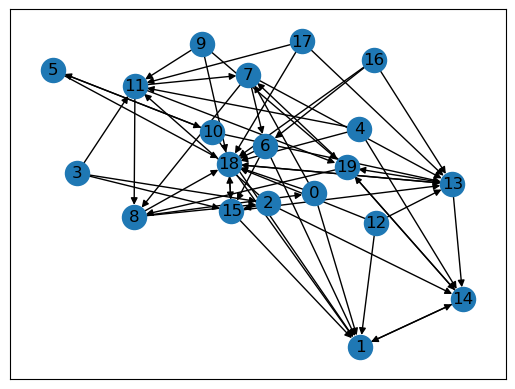

In [185]:
nx.draw_networkx(G)

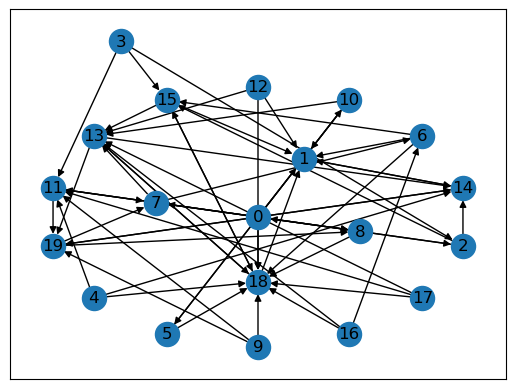

In [186]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

In [187]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_56722/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.0262,
 1: 0.156,
 2: 0.0283,
 3: 0.0075,
 4: 0.0075,
 5: 0.0109,
 6: 0.0258,
 7: 0.0572,
 8: 0.066,
 9: 0.0075,
 10: 0.0122,
 11: 0.024,
 12: 0.0075,
 13: 0.0739,
 14: 0.2067,
 15: 0.0509,
 16: 0.0075,
 17: 0.0075,
 18: 0.0916,
 19: 0.1252}

In [188]:
t

17

In [189]:
Q, t = q_rank(G, .85)
Q

{0: 0.0256,
 1: 0.1853,
 2: 0.0282,
 3: 0.0095,
 4: 0.0095,
 5: 0.0149,
 6: 0.0262,
 7: 0.0524,
 8: 0.0597,
 9: 0.0095,
 10: 0.0149,
 11: 0.0274,
 12: 0.0095,
 13: 0.0741,
 14: 0.1849,
 15: 0.0515,
 16: 0.0095,
 17: 0.0095,
 18: 0.0917,
 19: 0.106}

In [190]:
t

14

In [191]:
P1 = np.real(list(P.values()))
P1

array([0.0262, 0.156 , 0.0283, 0.0075, 0.0075, 0.0109, 0.0258, 0.0572,
       0.066 , 0.0075, 0.0122, 0.024 , 0.0075, 0.0739, 0.2067, 0.0509,
       0.0075, 0.0075, 0.0916, 0.1252])

In [192]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0256, 0.1853, 0.0282, 0.0095, 0.0095, 0.0149, 0.0262, 0.0524,
       0.0597, 0.0095, 0.0149, 0.0274, 0.0095, 0.0741, 0.1849, 0.0515,
       0.0095, 0.0095, 0.0917, 0.106 ])

In [193]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

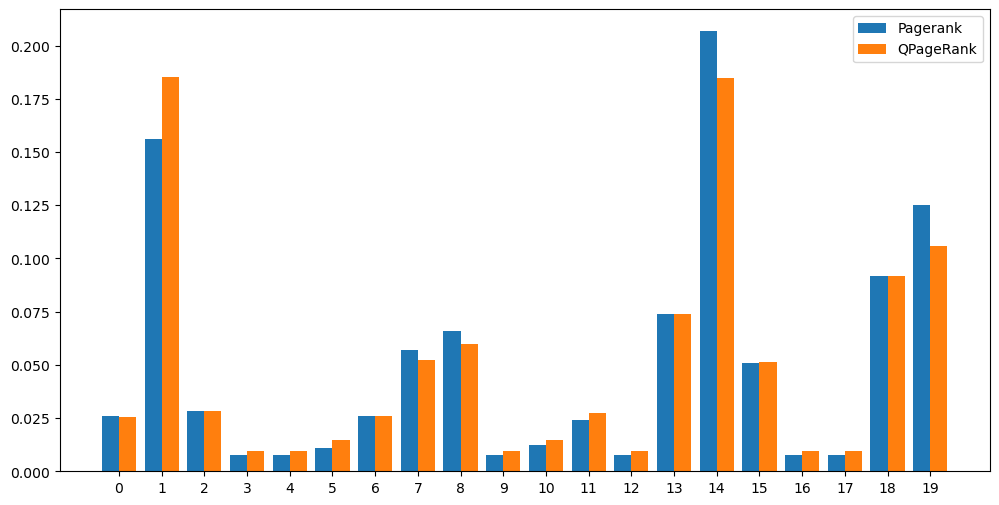

In [194]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [195]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 10,
 1: 2,
 2: 9,
 3: 15,
 4: 16,
 5: 14,
 6: 11,
 7: 7,
 8: 6,
 9: 17,
 10: 13,
 11: 12,
 12: 18,
 13: 5,
 14: 1,
 15: 8,
 16: 19,
 17: 20,
 18: 4,
 19: 3}

In [196]:
qPageRanks = find_ranks_of_vertices(Q)
qPageRanks

{0: 12,
 1: 1,
 2: 9,
 3: 15,
 4: 16,
 5: 13,
 6: 11,
 7: 7,
 8: 6,
 9: 17,
 10: 14,
 11: 10,
 12: 18,
 13: 5,
 14: 2,
 15: 8,
 16: 19,
 17: 20,
 18: 4,
 19: 3}

In [197]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [198]:
df["PageRanks"].corr(df["qPageRanks"])

0.9909774436090225

In [199]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
PageRanks   10   2   9  15  16  14  11   7   6  17  13  12  18   5   1   8   
qPageRanks  12   1   9  15  16  13  11   7   6  17  14  10  18   5   2   8   

            16  17  18  19  
PageRanks   19  20   4   3  
qPageRanks  19  20   4   3  


### GNC network

P. L. Krapivsky and S. Redner, Network Growth by Copying, Phys. Rev. E, 71, 036118, 2005k.}

https://networkx.org/documentation/stable/reference/generated/networkx.generators.directed.gnc_graph.html

Here the graph may have loops in the vertices. We remove the loops after generating the graph. Also, we calculate the ranks for connected graphs only.

In [200]:
H = nx.gnc_graph(20, create_using=None, seed=None)
H.remove_edges_from(nx.selfloop_edges(H))
nx.is_weakly_connected(H)

True

In [201]:
V = list(H.nodes())
V

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [202]:
E = list(H.edges())
E

[(1, 0),
 (2, 0),
 (2, 1),
 (3, 0),
 (4, 0),
 (5, 0),
 (5, 4),
 (6, 0),
 (6, 3),
 (7, 0),
 (7, 3),
 (8, 0),
 (9, 0),
 (9, 3),
 (9, 7),
 (10, 0),
 (10, 4),
 (11, 0),
 (11, 1),
 (12, 0),
 (13, 0),
 (13, 1),
 (13, 11),
 (14, 0),
 (14, 3),
 (15, 0),
 (15, 1),
 (16, 0),
 (16, 3),
 (16, 14),
 (17, 0),
 (17, 1),
 (17, 2),
 (18, 0),
 (18, 1),
 (18, 11),
 (19, 0),
 (19, 1),
 (19, 15)]

In [203]:
V = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
E = [(1, 0), (2, 0), (2, 1), (3, 0), (4, 0), (5, 0), (5, 4), (6, 0), (6, 3), (7, 0), (7, 3), (8, 0), (9, 0), (9, 3),
 (9, 7), (10, 0), (10, 4), (11, 0), (11, 1), (12, 0), (13, 0), (13, 1), (13, 11), (14, 0), (14, 3), (15, 0), (15, 1),
 (16, 0), (16, 3), (16, 14), (17, 0), (17, 1), (17, 2), (18, 0), (18, 1), (18, 11), (19, 0), (19, 1), (19, 15)]
G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(E)

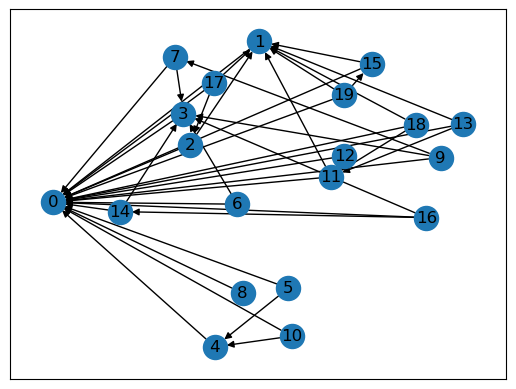

In [204]:
nx.draw_networkx(G)

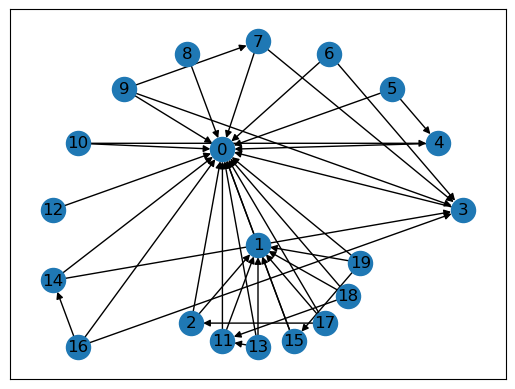

In [205]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

In [206]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_56722/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.3766,
 1: 0.0914,
 2: 0.0302,
 3: 0.0725,
 4: 0.0435,
 5: 0.0235,
 6: 0.0235,
 7: 0.0302,
 8: 0.0235,
 9: 0.0235,
 10: 0.0235,
 11: 0.0368,
 12: 0.0235,
 13: 0.0235,
 14: 0.0302,
 15: 0.0302,
 16: 0.0235,
 17: 0.0235,
 18: 0.0235,
 19: 0.0235}

In [207]:
t

11

In [208]:
Q, t = q_rank(G, .85)
Q

{0: 0.7062,
 1: 0.0482,
 2: 0.0133,
 3: 0.0383,
 4: 0.0234,
 5: 0.0105,
 6: 0.0105,
 7: 0.0133,
 8: 0.013,
 9: 0.0095,
 10: 0.0105,
 11: 0.0161,
 12: 0.013,
 13: 0.0095,
 14: 0.0133,
 15: 0.0133,
 16: 0.0095,
 17: 0.0095,
 18: 0.0095,
 19: 0.0095}

In [209]:
t

14

In [210]:
P1 = np.real(list(P.values()))
P1

array([0.3766, 0.0914, 0.0302, 0.0725, 0.0435, 0.0235, 0.0235, 0.0302,
       0.0235, 0.0235, 0.0235, 0.0368, 0.0235, 0.0235, 0.0302, 0.0302,
       0.0235, 0.0235, 0.0235, 0.0235])

In [211]:
Q1 = np.real(list(Q.values()))
Q1

array([0.7062, 0.0482, 0.0133, 0.0383, 0.0234, 0.0105, 0.0105, 0.0133,
       0.013 , 0.0095, 0.0105, 0.0161, 0.013 , 0.0095, 0.0133, 0.0133,
       0.0095, 0.0095, 0.0095, 0.0095])

In [212]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

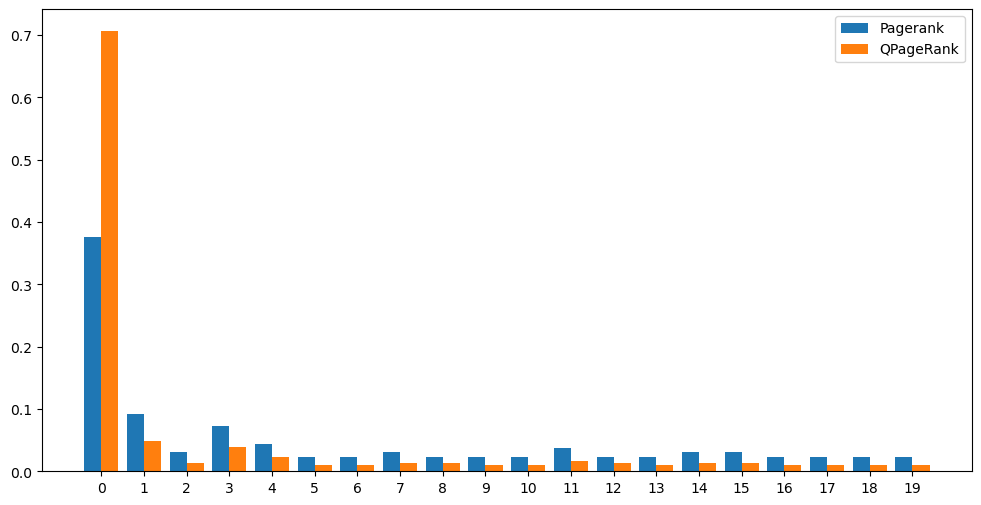

In [213]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [108]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 1,
 1: 2,
 2: 5,
 3: 3,
 4: 4,
 5: 7,
 6: 12,
 7: 6,
 8: 11,
 9: 9,
 10: 8,
 11: 13,
 12: 14,
 13: 15,
 14: 10,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20}

In [109]:
qPageRanks = find_ranks_of_vertices(Q)
qPageRanks

{0: 1,
 1: 2,
 2: 4,
 3: 3,
 4: 5,
 5: 6,
 6: 15,
 7: 8,
 8: 12,
 9: 9,
 10: 7,
 11: 16,
 12: 17,
 13: 20,
 14: 11,
 15: 10,
 16: 13,
 17: 18,
 18: 14,
 19: 19}

In [110]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [111]:
df["PageRanks"].corr(df["qPageRanks"])

0.8947368421052632

In [112]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
PageRanks    1   2   5   3   4   7  12   6  11   9   8  13  14  15  10  16   
qPageRanks   1   2   4   3   5   6  15   8  12   9   7  16  17  20  11  10   

            16  17  18  19  
PageRanks   17  18  19  20  
qPageRanks  13  18  14  19  
